# Influence function estimation at Univerity of Iowa
xchong@lbl.gov, 17th July 2024
awojdyla@lbl.gov

We try to train a DL model to reconstruct the influence function from random data.

In [1]:
# load the influence funtion from file
import numpy as np
import scipy.io as sc
import matplotlib.pyplot as plt  
import math


# 1 extract the random data from the npy files

In [2]:
# load the data from txt files
input = np.load("./seg3A_cells_1-16_randomVolts_voltMaps.npy")
result = np.load("./result.npy")

input = input[:,:16]
result = result.transpose((1,0))

print(input.shape, result.shape)

(418, 16) (418, 1400)


In [3]:
# remove bad cells 0,1,3 
input_cleaned=[]
for i in range(input.shape[0]):
    input_each=input[i]
    input_each_cleaned= np.delete(input_each, [0,1,3])
    input_cleaned.append(input_each_cleaned)
input_cleaned= np.array(input_cleaned)
print(input_cleaned[0],result[0])


[ 7.2656  4.8535  3.4229  4.6057 -6.5625  8.0261 -3.5315 -4.6387 -6.7456
 -6.0168 -5.8789 -4.5471  2.1924] [0.00395745 0.00393981 0.00392927 ... 0.00669889 0.00674388 0.00678038]


# 2 train a model D to predict result from random voltages

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# random seed
torch.manual_seed(0)


# class Discriminator(nn.Module):
#     def __init__(self, input_dim,output_dim):
#         super(Discriminator, self).__init__()
#         self.layer1 = nn.Linear(input_dim, 128)
#         self.layer2 = nn.Linear(128, 256)
#         self.layer3 = nn.Linear(256, output_dim)
    
#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         return x
from arch_unet import UNet
from torch.nn import functional as F
class Discriminator(nn.Module):
    def __init__(self, input_dim,output_dim):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Linear(input_dim, 1024)
        self.UNet = UNet()
        #self.layer11 = nn.Linear(512, 1024)
        self.layer2 = nn.Linear(1024, 2048)
        self.layer3 = nn.Linear(2048, output_dim)
        self.tanh = nn.Tanh()
        self.drop1 = nn.Dropout(0.1)
        self.drop2 = nn.Dropout(0.1)
        self.drop3 = nn.Dropout(0.1)
        # self.layer1 = nn.Linear(20, 128)
        # self.layer2 = nn.Linear(128, 256)
        # self.layer3 = nn.Linear(256, 41)


    def forward(self, x):
        x = self.layer1(x)
        # x = F.relu(x)
        # x = self.drop1(x)

        b,_= x.shape
        x = x.reshape(b,1,32,32)
        x = self.UNet(x)
        x = x.reshape(b,-1)


        x = self.layer2(x)
        # x = F.relu(x)
        # x = self.drop2(x)

        x = self.layer3(x)

        return x
    
class DataLoader_train(Dataset):
    def __init__(self,input_list,result_list):
        super(DataLoader_train, self).__init__()
  
        
        self.train_x = input_list
        self.train_result = result_list

        print('fetch {} samples for training'.format(len(self.train_x)))

    def __getitem__(self, index):

        x = self.train_x[index]
        result = self.train_result[index]

        x = np.array(x, dtype=np.float32)
        result = np.array(result, dtype=np.float32)


        x = torch.from_numpy(x)
        result = torch.from_numpy(result)

        return x,result

    def __len__(self):
        return len(self.train_x)
    
TrainingDataset = DataLoader_train(input_cleaned,result)
TrainingLoader = DataLoader(dataset=TrainingDataset,
                            num_workers=0,
                            batch_size=256,
                            shuffle=False,
                            pin_memory=False,
                            drop_last=True)


input_dim = 13
output_dim = 1400

cuda
fetch 418 samples for training


In [5]:
#train the model D and save it to D.ckpt (if already trained, skip this step)
D = Discriminator(input_dim,output_dim).to(device)
optimizer_D = optim.Adam(D.parameters(), lr=0.0001,weight_decay=1e-8)


D = D.to(device)

num_epochs = 200000
batch_size = 256

best_loss = float('inf')
best_D = D

for epoch in range(num_epochs):

    D.train()
    for iteration, data in enumerate(TrainingLoader):
        x, result = data
        x = x.to(device)
        result = result.to(device)
        optimizer_D.zero_grad()
        predict = D(x)
        diff = result*1e3 - predict
        loss = torch.mean(diff**2)*1000
  
        loss.backward()
        optimizer_D.step()
        if (epoch + 1) % 10000 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
            
        # update the best result
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_D = D


torch.save(best_D.state_dict(), "./D.ckpt")

/global/homes/x/xchong/.local/perlmutter/python-3.11/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch [10000/200000], Loss: 7.8776
Epoch [20000/200000], Loss: 0.0963
Epoch [40000/200000], Loss: 0.4994
Epoch [50000/200000], Loss: 0.4416
Epoch [60000/200000], Loss: 0.0600
Epoch [70000/200000], Loss: 0.0348
Epoch [80000/200000], Loss: 0.0181
Epoch [90000/200000], Loss: 0.9961
Epoch [100000/200000], Loss: 0.1519
Epoch [110000/200000], Loss: 0.0010
Epoch [120000/200000], Loss: 0.0028
Epoch [130000/200000], Loss: 0.0026
Epoch [140000/200000], Loss: 0.0069
Epoch [150000/200000], Loss: 0.1267
Epoch [160000/200000], Loss: 2.3355
Epoch [170000/200000], Loss: 0.0161
Epoch [180000/200000], Loss: 0.0039
Epoch [190000/200000], Loss: 0.0367
Epoch [200000/200000], Loss: 0.0005


In [6]:
# load the trained model 
D = Discriminator(input_dim,output_dim).to(device)
D.load_state_dict(torch.load("./D.ckpt"))
D.eval()

Discriminator(
  (layer1): Linear(in_features=13, out_features=1024, bias=True)
  (UNet): UNet(
    (head): Sequential(
      (0): LR(
        (block): Sequential(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.1, inplace=True)
        )
      )
      (1): LR(
        (block): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.1, inplace=True)
        )
      )
    )
    (down_path): ModuleList(
      (0-2): 3 x LR(
        (block): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): LeakyReLU(negative_slope=0.1, inplace=True)
        )
      )
    )
    (up_path): ModuleList(
      (0): UP(
        (conv_1): LR(
          (block): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.1, inp

In [7]:
# get the test sample (x= solution_V, y = wavefront_w)

y_mm = np.linspace(-40,40,1664)
crop_start = 150
crop_end = 1550
y_mm = y_mm[crop_start:crop_end]
y_mm = np.expand_dims(y_mm, axis=1)

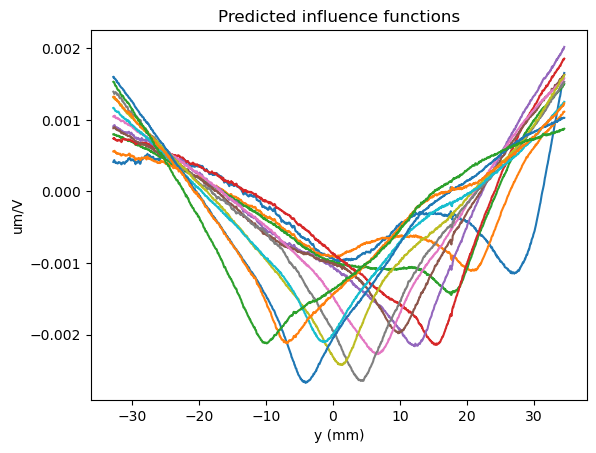

In [8]:
# reconstruct the influence function by applying 10V to each cell 
for param in D.parameters():
    param.requires_grad = False



ifs=[]
for i in range(13):
    test_input = np.zeros(13, dtype=np.float32)
    test_input[i] = 10
    test_input = np.expand_dims(test_input, axis=0)

    D_w = D(torch.from_numpy(test_input).cuda()).squeeze()
    D_w = D_w.cpu()*1e-3

    ifs.append(D_w)
    
ifs=np.array(ifs).transpose((1,0))
plt.plot(y_mm, ifs)

plt.title("Predicted influence functions")
plt.xlabel("y (mm)")
plt.ylabel("um/V")
plt.show()

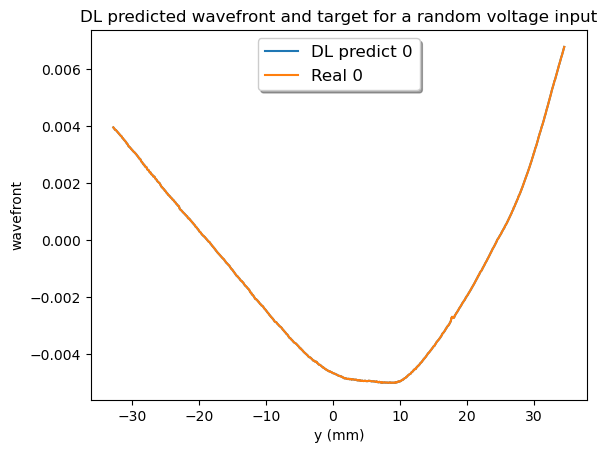

In [9]:
#plot the predicted wavefront and the target wavefront for a random voltage input
for param in D.parameters():
    param.requires_grad = False



test_index=100
for test_index in range(1):
    test_input = input_cleaned[test_index].astype(np.float32)
    test_input = np.expand_dims(test_input, axis=0)
    D_w = D(torch.from_numpy(test_input).cuda()).squeeze()
    D_w = D_w.cpu()*1e-3



    plt.plot(y_mm, D_w,label="DL predict "+str(test_index))
    plt.plot(y_mm, result[test_index].cpu(),label="Real "+str(test_index))

plt.legend(loc='upper center', shadow=True, fontsize='large')
plt.title("DL predicted wavefront and target for a random voltage input")
plt.xlabel("y (mm)")
plt.ylabel("wavefront")
plt.show()